In [1]:
import tensorflow as tf
from keras.datasets import mnist
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import time

In [2]:
seed = 1
tf.random.set_seed(seed)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [4]:
class TrainingTimeCallback(tf.keras.callbacks.Callback) :
    def on_train_begin(self, logs=None) :
        self.times = []
    
    def on_epoch_begin(self, epoch, logs=None) :
        self.epoch_time_start = time.time()
        
    def on_epoch_end(self, epoch, logs=None) :
        self.times.append(time.time() - self.epoch_time_start)    

In [71]:
EPOCHS = 30
BATCH_SIZE = 200

In [77]:
class CNNModel() :
    def __init__(self, model_name = '', n_conv_layers = 1, n_features = 8, dense_layer_size = 16, early_stopping_patience = 0, dropout = 0) :
        
        if model_name == '' :
            self.model_name = self.model_name = '{}C, {}F, {}D'.format(n_conv_layers, n_features, dense_layer_size)
        else :
            self.model_name = model_name
            
        self.early_stopping_patience = early_stopping_patience
        self.dropout = dropout
        
        self.model = self.build_model(n_conv_layers, n_features, dense_layer_size) 
        
    def build_model(self, n_conv_layers, n_features, size_dense_layer) :
        model = tf.keras.Sequential()
        
        for i in range(n_conv_layers) :
            model.add(tf.keras.layers.Conv2D(n_features * (i+1), kernel_size=5, input_shape = (28, 28, 1), padding='same', activation='relu'))
            model.add(tf.keras.layers.MaxPooling2D(pool_size=2, padding='same'))      
            
            if (self.dropout > 0) :
                model.add(tf.keras.layers.Dropout(self.dropout))  
        
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(size_dense_layer, activation='relu'))
        
        if (self.dropout > 0) :
                model.add(tf.keras.layers.Dropout(self.dropout))  
                
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    def fit(self, x_train, y_train, x_test, y_test) :
        self.training_time = TrainingTimeCallback()
        callbacks = [self.training_time]
        
        if self.early_stopping_patience > 0 :
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=self.early_stopping_patience, restore_best_weights=True)
            callbacks.append(early_stopping)
            
        self.history = self.model.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=2, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks) 
        

In [ ]:
models = [
    CNNModel(model_name='ES 0', n_conv_layers=3, n_features=32, dense_layer_size=100, early_stopping_patience=0, dropout=0.3),
    CNNModel(model_name='ES 2', n_conv_layers=3, n_features=32, dense_layer_size=100, early_stopping_patience=2, dropout=0.3),
    CNNModel(model_name='ES 4', n_conv_layers=3, n_features=32, dense_layer_size=200, early_stopping_patience=4, dropout=0.3),
    CNNModel(model_name='ES 8', n_conv_layers=3, n_features=32, dense_layer_size=300, early_stopping_patience=8, dropout=0.3)
]

for model in models :
    model.fit(x_train, y_train, x_test, y_test)

ES 0: train_acc 0.9954166412353516, val_acc 0.9945999979972839
ES 2: train_acc 0.9922333359718323, val_acc 0.9941999912261963
ES 4: train_acc 0.9944666624069214, val_acc 0.9945999979972839
ES 8: train_acc 0.9961166381835938, val_acc 0.9952999949455261


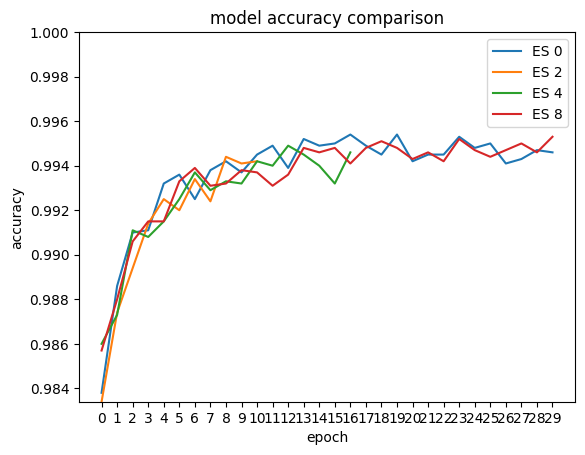

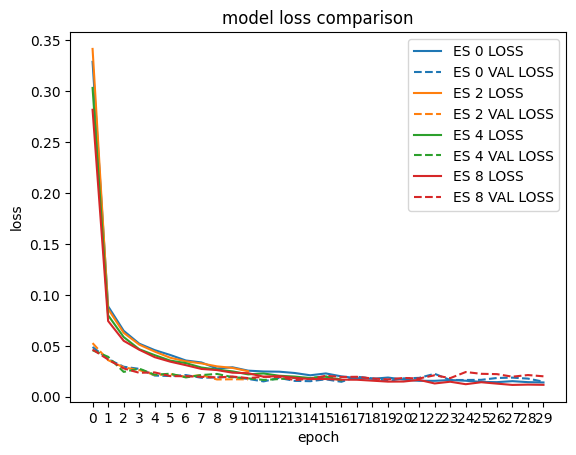

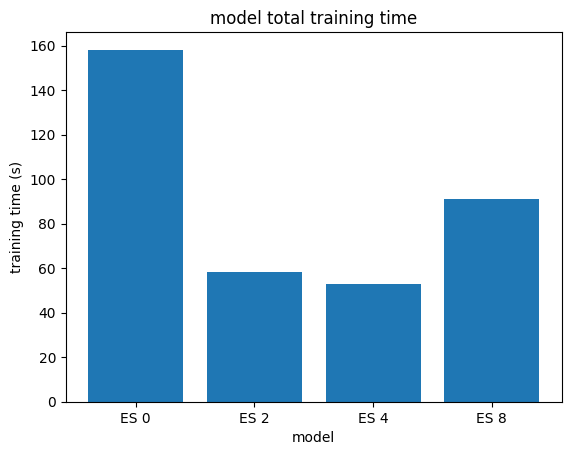

In [79]:
def plot_accuracy(models) :
    fig, ax = plt.subplots()

    for model in models :
        ax.plot(model.history.history['val_accuracy'])
    
    ax.set_title('model accuracy comparison')
    ax.set_ylabel('accuracy')   
    ax.set_xlabel('epoch') 
    ax.set_xticks(range(0, EPOCHS))
    ax.set_ylim([min(map(lambda model: min(model.history.history['val_accuracy']), models)), 1])

    plt.legend([model.model_name for model in models])
    plt.show()

def plot_training_time_per_epoch(models) :
    fig, ax = plt.subplots()

    for model in models :
        ax.plot(model.training_time.times)
    
    ax.set_title('model training time per epoch')
    ax.set_ylabel('training time (s)')   
    ax.set_xlabel('epoch') 
    ax.set_xticks(range(0, EPOCHS))
    ax.set_ylim([min(map(lambda model: min(model.training_time.times), models)), max(map(lambda model: max(model.training_time.times), models))])

    plt.legend([model.model_name for model in models])
    plt.show()    
    
def plot_total_training_time(models) :
    fig, ax = plt.subplots()

    x = [model.model_name for model in models]
    y = [sum(model.training_time.times) for model in models]

    ax.bar(x, y)
    
    ax.set_title('model total training time')
    ax.set_ylabel('training time (s)')   
    ax.set_xlabel('model') 

    plt.show()    
    
def plot_loss_per_epoch(models) :
    fig, ax = plt.subplots()
    
    names = []

    for model in models :
        names.append(model.model_name + " LOSS")
        names.append(model.model_name + " VAL LOSS")
        ax.plot(model.history.history['loss'])
        ax.plot(model.history.history['val_loss'], linestyle='dashed', c = ax.get_lines()[-1].get_color())
    
    ax.set_title('model loss comparison')
    ax.set_ylabel('loss')   
    ax.set_xlabel('epoch') 
    ax.set_xticks(range(0, EPOCHS))

    plt.legend(names)
    plt.show()

for model in models :
    train_acc = model.history.history['accuracy'][-1]
    val_acc = model.history.history['val_accuracy'][-1]
    print('{}: train_acc {}, val_acc {}'.format(model.model_name, train_acc, val_acc))

plot_accuracy(models)
plot_loss_per_epoch(models)
plot_total_training_time(models)